## 👓 Objetivo: profundizar y testear con text embeddings 👓

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import numpy as np
import matplotlib.pyplot as plt
#import seaborn

### PyTorch version of EMBEDDING layer:
    
''' nn.Embedding(numb_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2., scale_grad_by_freq=False, sparse=False, _weight=None) '''

* num_embeddings: the size of the dictionary of embeddings, the number of embeddings
* embedding_dim: the size of each embedding vector e.g. 16, 32
* padding_idx: the position of the "<PAD>" token in the vocabulary, if any
* max_norm: maximum norm of the word embedding in the embedding matrix
* norm_type: type of p-norm used to compute the norm over embeddings, by default 2 (euclidean distance)
* scale_grad_by_freq: Boolean indicating whether to scale the gradients by the word frequency
* sparse: boolean to decide whether to allocate sparse tensor of dense tensor
* _weight: initial weights for the embeddings, can be None for the default initializer

### Tensorflow Keras version of EMBEDDING layer:

from tensorflow.keras.layers import Embedding

➡️ Define Keras Embedding layer which is equivalent to PyTorch nn.Embedding layer <br>
''' keras_embedding = Embedding(input_dim=num_embeddings, output_dim=embedding_dim, input_length=max_len, mask_zero=True) '''

* num_embeddings: the size of the dictionary of embeddings, the number of embeddings
* embedding_dim: the size of each embedding vector e.g. 16, 32
* max_len: maximum length of sequence
* mask_zero: boolean for whether or not input value 0 is a special "padding" value that should be masked out

➡️ Convert text to indices
padded_input_ids = tf.keras.preprocessing.sequence.pad_sequences([[word2id[word] for word in sentence.split()]], maxlen=max_len, padding='post')

👉🏼 Get word embeddings
keras_word_embeddings = keras_embedding(padded_input_ids)


# Section 1: Encoding Natural Language - Word Embedding and Positional Encoding

In this section we'll look at how to take a natural language input and convert it to the form we'll need for our transformer.

In [3]:
#MY CODE
import llms_utils 

utils_obj = llms_utils.TextUtils()

In [21]:
#MY CODE
# Define a sentence and a simple word2id mapping
sentence = "The quick brown fox jumps over the lazy dog"

word2id = utils_obj.build_word2id_dict(sentence)
word2id

{'quick': 0,
 'over': 1,
 'the': 2,
 'The': 3,
 'dog': 4,
 'jumps': 5,
 'brown': 6,
 'fox': 7,
 'lazy': 8}

#### Utilizamos la tarjeta gráfica de MAC

In [22]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


#### Instanciamos la semilla

In [10]:
#torch.manual_seed(42)

In [41]:
# Define a sentence and a simple word2id mapping
sentence = "The quick brown fox jumps over the lazy dog"

word2id = {word: i for i, word in enumerate(set(sentence.split()))}
print(word2id)
# Convert text to indices
input_ids = torch.tensor([word2id[word] for word in sentence.split()])
print(input_ids)
# Define a simple word embedding function
def get_word_embeddings(input_ids, embedding_size):
    embedding_layer = nn.Embedding(input_ids.max() + 1, embedding_size) #, device=device)
    return embedding_layer(input_ids)


# Get word embeddings
embedding_size = 16  # Size of the word embeddings
word_embeddings = get_word_embeddings(input_ids, embedding_size)
print(word_embeddings)

{'quick': 0, 'over': 1, 'the': 2, 'The': 3, 'dog': 4, 'jumps': 5, 'brown': 6, 'fox': 7, 'lazy': 8}
tensor([3, 0, 6, 7, 5, 1, 2, 8, 4])
tensor([[ 0.5574,  0.2451,  0.4350,  0.6973,  0.8760,  2.6716,  0.3918,  0.3952,
          1.2747, -0.9177,  0.4157, -0.4075,  0.9923, -1.3877,  0.3948, -1.4777],
        [-1.0674,  0.4435,  0.0205,  2.6020, -0.7130,  0.2537,  0.0205, -1.1247,
          0.3154, -0.6165,  0.6415,  1.4002,  1.8672, -0.0752, -0.9531,  0.1191],
        [ 1.4452,  0.3112, -1.3713, -0.0933,  0.8852, -1.6276, -1.6121,  1.1411,
          0.8997,  0.6261,  0.6117, -1.0134, -0.1879,  0.6510,  0.6217,  0.0062],
        [ 0.0060,  0.2920, -0.0093,  0.4957,  0.2671,  0.9351, -0.3202,  0.5730,
         -0.0888, -0.6626,  0.3374, -0.5206, -0.7910,  0.0702, -0.2970,  0.1975],
        [ 0.9992, -1.9083, -0.8177,  0.7192, -0.3442,  1.7931, -0.8803, -0.3530,
         -0.4009,  0.5728, -2.1914, -0.2661,  0.6657, -0.8517,  0.6696, -2.6116],
        [-0.0634,  0.3462,  0.0466,  0.5776,  0.78

### 📊 Ploteamos una proyección bidimensional de los word embeddings:

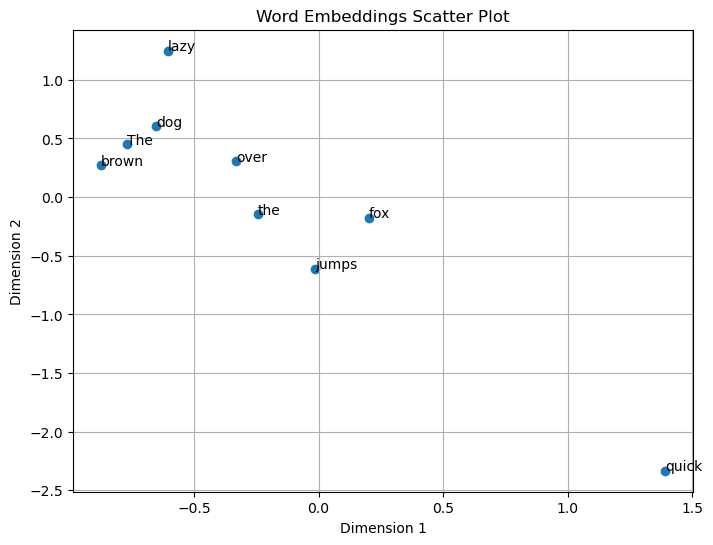

In [24]:
import matplotlib.pyplot as plt

words = [word for word in word2id.keys()]
word_embeddings_np = word_embeddings.detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter([e[0] for e in word_embeddings_np], [e[1] for e in word_embeddings_np])

for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_np[i][0], word_embeddings_np[i][1]))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.grid(True)
plt.show()

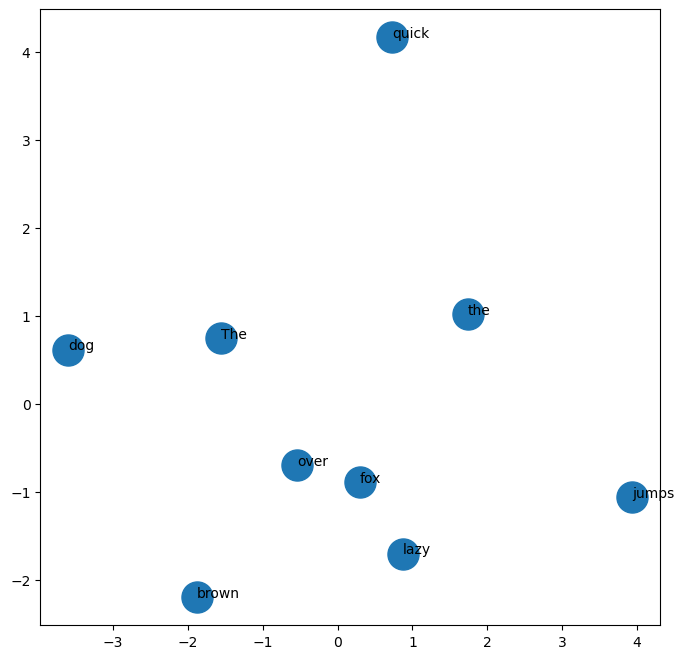

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(word_embeddings_np)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

📝 Y si indicamos las distancias euclídeas en un dataset?

In [26]:
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import euclidean

# Obtén todas las combinaciones posibles de pares de palabras
word_pairs = list(combinations(word2id.keys(), 2))

# Calcula la distancia euclidiana entre los vectores de embedding de cada par de palabras
distances = [euclidean(word_embeddings.detach().numpy()[word2id[pair[0]]], word_embeddings.detach().numpy()[word2id[pair[1]]])
             for pair in word_pairs]

# Crea el DataFrame con las columnas "words_pair" y "euclidean distance"
df = pd.DataFrame({'words_pair': word_pairs, 'euclidean distance': distances})

# Imprime el DataFrame
df_sorted = df.sort_values(by='euclidean distance', ascending=False)
df_sorted

,words_pair,euclidean distance
26,"(dog, jumps)",7.911731
5,"(quick, brown)",7.269791
4,"(quick, jumps)",6.953355
7,"(quick, lazy)",6.906088
22,"(The, jumps)",6.759875
30,"(jumps, brown)",6.729637
29,"(dog, lazy)",6.670320
3,"(quick, dog)",6.455326
18,"(the, brown)",6.300898
32,"(jumps, lazy)",6.195836


#### repito ejecución para comprobar si esos embeddings de nn.Embedding() son deterministas:

In [27]:
print(word2id)
# Convert text to indices
input_ids = torch.tensor([word2id[word] for word in sentence.split()])
print(input_ids)
# Define a simple word embedding function
def get_word_embeddings(input_ids, embedding_size):
    embedding_layer = nn.Embedding(input_ids.max() + 1, embedding_size)
    return embedding_layer(input_ids)

# Get word embeddings
embedding_size = 16  # Size of the word embeddings
word_embeddings = get_word_embeddings(input_ids, embedding_size)
print(word_embeddings)

{'quick': 0, 'over': 1, 'the': 2, 'The': 3, 'dog': 4, 'jumps': 5, 'brown': 6, 'fox': 7, 'lazy': 8}
tensor([3, 0, 6, 7, 5, 1, 2, 8, 4])
tensor([[-1.6612, -1.0020, -2.2025,  1.0553,  1.2891, -0.7451,  2.1891, -1.3301,
          0.8464, -0.7996,  0.6703, -1.0075,  1.4850,  2.5548, -0.6210,  1.0162],
        [ 0.5905, -1.3776, -0.3737,  0.5174,  0.2253, -2.3812, -0.3832, -0.0700,
          0.4548,  1.4064,  2.1506, -0.4381,  0.8121,  0.3310,  0.4204, -0.7358],
        [ 0.3845,  0.8338,  0.1613, -0.1071, -1.0887, -1.5014,  0.3182,  0.5048,
         -2.1801, -2.2188, -0.6732,  0.5603, -0.1525, -0.1516,  0.1497,  1.5667],
        [ 0.0988,  1.7426,  0.1188, -0.3834, -0.2502, -1.0599, -0.6007,  0.6621,
         -1.0752, -1.6325, -0.2848,  0.8764, -0.7111,  1.3218,  0.5374, -1.8417],
        [-0.1622, -0.6693, -0.3891,  1.0311,  1.1554, -0.3061,  0.1790, -0.7115,
         -0.3351, -0.1473, -0.8821,  1.2262, -0.4915, -2.8090,  1.0136, -0.9723],
        [-0.2291, -0.3964,  0.9741, -0.2161,  0.27

In [28]:
# embedding_layer = nn.Embedding(input_ids.max() + 1, embedding_size)
# embedding_layer.from_pretrained()

### 📊 Ploteamos una proyección bidimensional de los word embeddings:

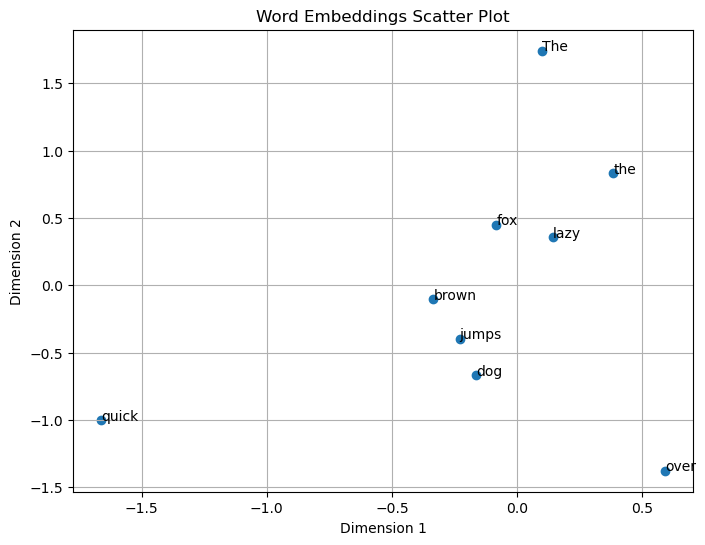

In [29]:
import matplotlib.pyplot as plt

words = [word for word in word2id.keys()]
word_embeddings_np = word_embeddings.detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter([e[0] for e in word_embeddings_np], [e[1] for e in word_embeddings_np])

for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_np[i][0], word_embeddings_np[i][1]))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.grid(True)
plt.show()

### 🧪  Y con PCA:

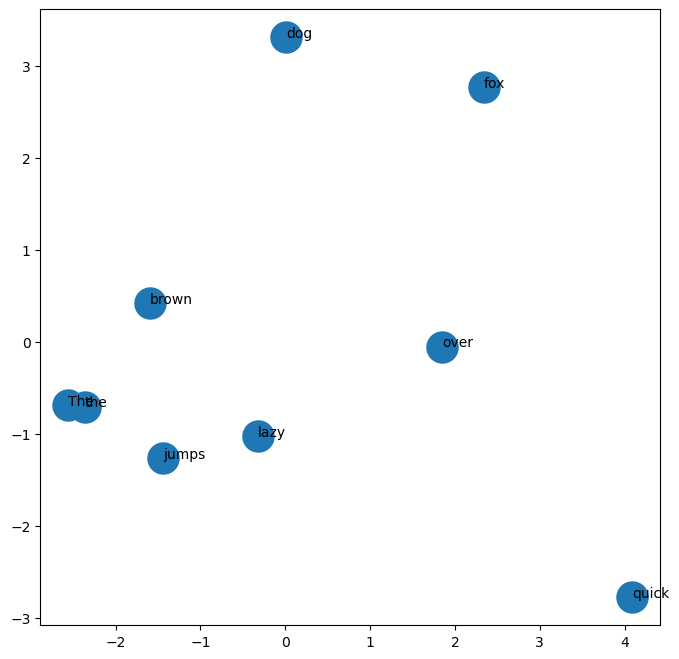

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(word_embeddings_np)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

📝 Y si indicamos las distancias euclídeas en un dataset?

In [31]:
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import euclidean

# Obtén todas las combinaciones posibles de pares de palabras
word_pairs = list(combinations(word2id.keys(), 2))

# Calcula la distancia euclidiana entre los vectores de embedding de cada par de palabras
distances = [euclidean(word_embeddings.detach().numpy()[word2id[pair[0]]], word_embeddings.detach().numpy()[word2id[pair[1]]])
             for pair in word_pairs]

# Crea el DataFrame con las columnas "words_pair" y "euclidean distance"
df = pd.DataFrame({'words_pair': word_pairs, 'euclidean distance': distances})

# Imprime el DataFrame
df_sorted = df.sort_values(by='euclidean distance', ascending=False)
df_sorted

,words_pair,euclidean distance
3,"(quick, dog)",7.668374
2,"(quick, The)",7.550513
5,"(quick, brown)",7.400934
1,"(quick, the)",7.343542
19,"(the, fox)",6.759847
8,"(over, the)",6.672688
24,"(The, fox)",6.601170
4,"(quick, jumps)",6.528902
31,"(jumps, fox)",6.464385
6,"(quick, fox)",6.295001


## ❗️ Probar con más vocabulario o con pretrained embeddings ❗️

In [42]:
import torch
import torchtext
import torch.nn as nn

# Carga los embeddings pre-entrenados
pretrained_embeddings = torchtext.vocab.GloVe(name='6B', dim=300)

# Obtiene el vector de una palabra específica
word_vector = pretrained_embeddings['The'].unsqueeze(0)
word_vector


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

➡️ contiene todo 0s porque no contiene esa palabra, sino la lower cased:

In [43]:
word_vector = pretrained_embeddings['the'].unsqueeze(0)
word_vector

tensor([[ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
          2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
         -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
          2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
         -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
         -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
          9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
         -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
          1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
          2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
          1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
          2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
         -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
         -4.4640e-01,  1.7197e-01,  4.

### 💡 ❓Tardaría mucho menos usando una base de datos vectorial que ya contenga esos embeddings? To check con Databricks? 💡💡💡 <p>

#### Ahora repetimos el análisis de similitud de palabras de antes con estos embeddings pre-entrenados:

In [44]:
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import euclidean

# Obtén todas las combinaciones posibles de pares de palabras
word_pairs = list(combinations(word2id.keys(), 2))

# Carga los embeddings pre-entrenados
pretrained_embeddings = torchtext.vocab.GloVe(name='6B', dim=300)

# Calcula la distancia euclidiana entre los vectores de embedding de cada par de palabras
distances = [euclidean(pretrained_embeddings[pair[0]], pretrained_embeddings[pair[1]])
             for pair in word_pairs]

# Crea el DataFrame con las columnas "words_pair" y "euclidean distance"
df = pd.DataFrame({'words_pair': word_pairs, 'euclidean distance': distances})

# Imprime el DataFrame
df_sorted = df.sort_values(by='euclidean distance', ascending=False)
df_sorted

,words_pair,euclidean distance
14,"(over, lazy)",8.471087
30,"(jumps, brown)",8.466522
20,"(the, lazy)",8.266583
31,"(jumps, fox)",8.260901
26,"(dog, jumps)",8.121976
10,"(over, dog)",8.059059
35,"(fox, lazy)",8.041628
34,"(brown, lazy)",8.015525
11,"(over, jumps)",7.997568
27,"(dog, brown)",7.942396


In [45]:
import pandas as pd
from itertools import combinations

# Obtén todas las combinaciones posibles de pares de palabras
word_pairs = list(combinations(word2id.keys(), 2))

# Carga los embeddings pre-entrenados
pretrained_embeddings = torchtext.vocab.GloVe(name='6B', dim=300)

# Calcula la distancia euclidiana entre los vectores de embedding de cada par de palabras
distances = [torch.cosine_similarity(pretrained_embeddings[pair[0]].unsqueeze(0), 
                                     pretrained_embeddings[pair[1]].unsqueeze(0))
             for pair in word_pairs]

# Crea el DataFrame con las columnas "words_pair" y "euclidean distance"
df = pd.DataFrame({'words_pair': word_pairs, 'cosine similarity': distances})

# Imprime el DataFrame
df_sorted = df.sort_values(by='cosine similarity', ascending=False)
df_sorted

,words_pair,cosine similarity
8,"(over, the)",[tensor(0.5247)]
29,"(dog, lazy)",[tensor(0.3721)]
33,"(brown, fox)",[tensor(0.3576)]
7,"(quick, lazy)",[tensor(0.3124)]
12,"(over, brown)",[tensor(0.3123)]
28,"(dog, fox)",[tensor(0.3036)]
18,"(the, brown)",[tensor(0.2825)]
4,"(quick, jumps)",[tensor(0.2801)]
1,"(quick, the)",[tensor(0.2688)]
5,"(quick, brown)",[tensor(0.2539)]


### 👓 Ahora probamos a representar gráficamente los embeddings proyectados en 2-D

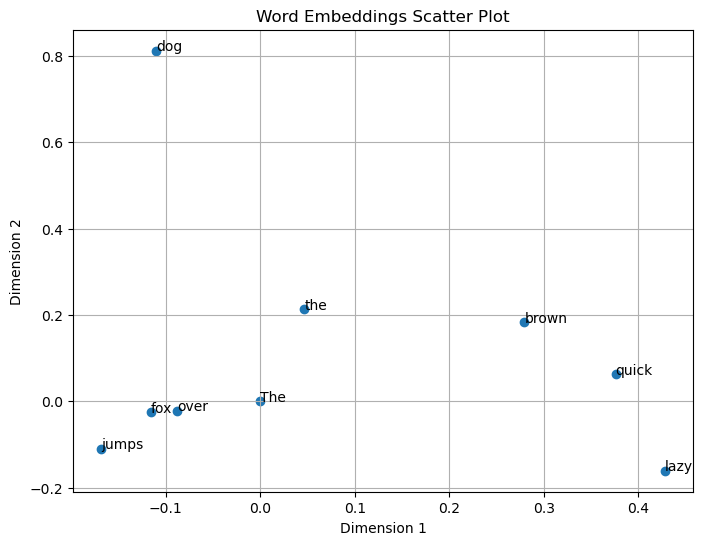

In [46]:
import matplotlib.pyplot as plt

words = [word for word in word2id.keys()]
word_embeddings_np = [pretrained_embeddings[word].unsqueeze(0)[0] for word in words] #word_embeddings.detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter([e[0] for e in word_embeddings_np], [e[1] for e in word_embeddings_np])

for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_np[i][0], word_embeddings_np[i][1]))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.grid(True)
plt.show()

In [58]:
word_embeddings_np = list([np.array(pretrained_embeddings[word].unsqueeze(0)[0]) for word in words])
word_embeddings_np[8]

array([ 4.2791e-01, -1.6070e-01,  2.4912e-01,  3.9763e-01, -3.2224e-01,
        1.9783e-04,  8.8576e-02,  4.0501e-01, -2.4655e-01,  1.6410e-02,
       -2.3331e-01, -1.2307e-01, -3.9679e-01,  2.1877e-02,  1.6211e-01,
        3.8852e-01,  2.5025e-01, -4.3968e-02,  1.0819e+00,  6.6517e-01,
        2.1829e-01,  7.9898e-01, -6.1695e-01, -1.0184e-01,  2.2900e-01,
       -3.1982e-01,  3.1205e-01, -1.0453e-01,  4.4810e-01,  3.6708e-02,
       -1.1376e-02,  7.0543e-01,  2.7454e-01,  2.5835e-01, -5.1821e-01,
        8.2996e-01, -8.0672e-02, -4.5489e-01, -3.4843e-01,  5.1421e-01,
       -5.7408e-01,  6.4612e-01, -2.1564e-01, -5.4848e-01,  2.3656e-01,
        1.8453e-02,  8.6403e-01, -1.0357e-01, -5.6097e-02, -4.8564e-01,
        2.7927e-01, -6.1733e-01,  5.2877e-01, -1.9221e-01, -1.4684e-01,
        4.2272e-01,  5.6312e-02, -3.3168e-01,  8.1864e-02,  2.2225e-01,
        2.7757e-01, -2.1934e-02,  2.8499e-01,  5.7453e-03, -4.0598e-01,
        6.1549e-02,  1.1544e-01,  7.2053e-02, -5.4945e-02, -3.95

### 🧪 Con PCA:

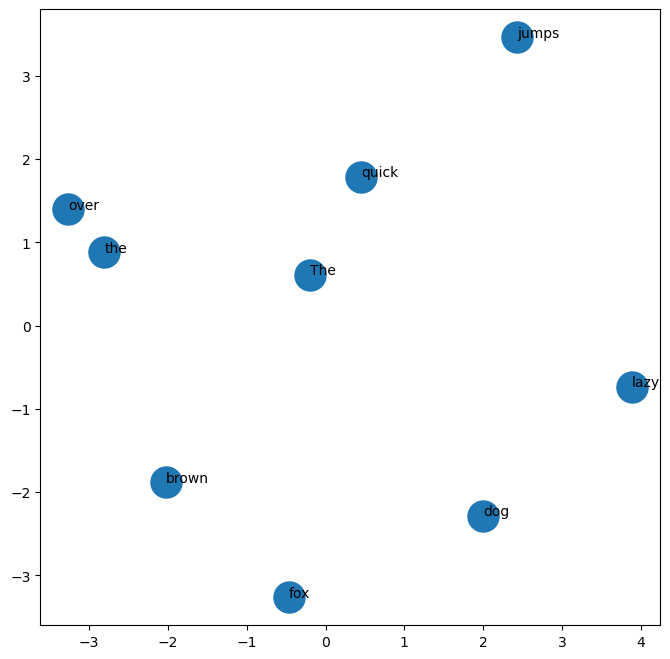

In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(word_embeddings_np)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

📙Construimos clase helper para librería de la funcionalidad generada:

In [17]:
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torchtext
import torch.nn as nn

class NLPHelper:
    def __init__(self):
        """
        Inicializa la clase NLPHelper.
        Carga los embeddings pre-entrenados.
        """
        self.pretrained_embeddings = torchtext.vocab.GloVe(name='6B', dim=300)
    
    def build_word2id(self, sentence):
        """
        Construye el diccionario word2id a partir de una oración.
        
        Args:
            sentence (str): La oración de entrada.
        
        Returns:
            dict: El diccionario word2id.
        """
        try:
            words = sentence.split()
            word2id = {word: i for i, word in enumerate(set(words))}
            return word2id
        except Exception as e:
            print(f"Error al construir el diccionario word2id: {e}")
    
    def build_id2word(self, word2id):
        """
        Construye el diccionario id2word a partir del diccionario word2id.
        
        Args:
            word2id (dict): El diccionario word2id.
        
        Returns:
            dict: El diccionario id2word.
        """
        try:
            id2word = {i: word for word, i in word2id.items()}
            return id2word
        except Exception as e:
            print(f"Error al construir el diccionario id2word: {e}")
    
    def get_word_vector(self, word):
        """
        Obtiene el vector de embedding de una palabra específica.
        
        Args:
            word (str): La palabra de entrada.
        
        Returns:
            torch.Tensor: El vector de embedding de la palabra.
        """
        try:
            word_vector = self.pretrained_embeddings[word].unsqueeze(0)
            return word_vector
        except Exception as e:
            print(f"Error al obtener el vector de la palabra: {e}")
    
    def process_text(self, text):
        """
        Procesa un texto dado.
        
        Args:
            text (str): El texto de entrada.
        
        Returns:
            str: El texto procesado.
        """
        try:
            processed_text = text.lower()
            return processed_text
        except Exception as e:
            print(f"Error al procesar el texto: {e}")
    
    def build_distance_dataset(self, word2id):
        """
        Construye el dataset de distancias euclidianas y similitud coseno a partir del diccionario word2id.
        
        Args:
            word2id (dict): El diccionario word2id.
        
        Returns:
            pd.DataFrame: El dataset de distancias.
        """
        try:
            word_pairs = list(combinations(word2id.keys(), 2))
            euclidean_distances = [euclidean(self.pretrained_embeddings[pair[0]].numpy(), self.pretrained_embeddings[pair[1]].numpy())
                                   for pair in word_pairs]
            cosine_similarities = [cosine_similarity(self.pretrained_embeddings[pair[0]].unsqueeze(0), self.pretrained_embeddings[pair[1]].unsqueeze(0)).item()
                                   for pair in word_pairs]
            df = pd.DataFrame({'words_pair': word_pairs, 'euclidean distance': euclidean_distances, 'cosine similarity': cosine_similarities})
            return df
        except Exception as e:
            print(f"Error al construir el dataset de distancias: {e}")

# Ejemplo de uso de la clase NLPHelper
nlp_helper = NLPHelper()

# Construir el diccionario word2id
sentence = "The quick brown fox jumps over the lazy dog"
word2id = nlp_helper.build_word2id(sentence)

# Construir el dataset de distancias euclidianas y similitud coseno
distance_dataset = nlp_helper.build_distance_dataset(word2id).sort_values(by='euclidean distance', ascending=False)
print("Dataset de distancias:")
print(distance_dataset)

Dataset de distancias:
        words_pair  euclidean distance  cosine similarity
14    (over, lazy)            8.471087           0.045960
30  (jumps, brown)            8.466522           0.066492
20     (the, lazy)            8.266583          -0.009492
31    (jumps, fox)            8.260901           0.160373
26    (dog, jumps)            8.121976           0.212458
10     (over, dog)            8.059059           0.178024
35     (fox, lazy)            8.041628           0.220345
34   (brown, lazy)            8.015525           0.181295
11   (over, jumps)            7.997568           0.130400
27    (dog, brown)            7.942396           0.232761
17    (the, jumps)            7.849084           0.068217
6     (quick, fox)            7.831755           0.190651
13     (over, fox)            7.813715           0.202138
3     (quick, dog)            7.777961           0.227852
28      (dog, fox)            7.767117           0.303579
32   (jumps, lazy)            7.739300           

In [18]:
import unittest

# Clase de pruebas unitarias para la clase NLPHelper
class NLPHelperTests(unittest.TestCase):
    def setUp(self):
        self.nlp_helper = NLPHelper()
    
    def test_build_word2id(self):
        sentence = "The quick brown fox jumps over the lazy dog"
        word2id = self.nlp_helper.build_word2id(sentence)
        self.assertIsInstance(word2id, dict)
        self.assertEqual(len(word2id), 8)
    
    def test_build_id2word(self):
        word2id = {'The': 0, 'quick': 1, 'brown': 2, 'fox': 3, 'jumps': 4, 'over': 5, 'the': 6, 'lazy': 7, 'dog': 8}
        id2word = self.nlp_helper.build_id2word(word2id)
        self.assertIsInstance(id2word, dict)
        self.assertEqual(len(id2word), 9)
    
    def test_get_word_vector(self):
        word = 'quick'
        word_vector = self.nlp_helper.get_word_vector(word)
        self.assertIsInstance(word_vector, torch.Tensor)
        self.assertEqual(word_vector.shape, torch.Size([1, 300]))
    
    def test_process_text(self):
        text = "The Quick Brown Fox"
        processed_text = self.nlp_helper.process_text(text)
        self.assertIsInstance(processed_text, str)
        self.assertEqual(processed_text, "the quick brown fox")
    
    def test_build_distance_dataset(self):
        self.setUp()
        word2id = {'The': 0, 'quick': 1, 'brown': 2, 'fox': 3, 'jumps': 4, 'over': 5, 'the': 6, 'lazy': 7, 'dog': 8}
        distance_dataset = self.nlp_helper.build_distance_dataset(word2id)
        #print('distance dataset: ', distance_dataset)
        self.assertIsInstance(distance_dataset, pd.DataFrame)
        self.assertEqual(distance_dataset.shape[0], 36)
        self.assertEqual(distance_dataset.shape[1], 3)

        self.distance_dataset = distance_dataset

        # Validación adicional de la funcionalidad
        similar_pair = ('fox', 'dog')
        dissimilar_pair = ('the', 'dog')
        
        similar_distance = distance_dataset[distance_dataset['words_pair'] == similar_pair]['euclidean distance'].values[0]
        dissimilar_distance =distance_dataset[distance_dataset['words_pair'] == dissimilar_pair]['euclidean distance'].values[0]
        
        self.assertGreater(similar_distance, dissimilar_distance)

# Ejecutar][as pruebas unitarias
'''
if __name__ == '__main__':
    unittest.main()'''
tester_obj = NLPHelperTests()
tester_obj.test_build_distance_dataset()

tester_obj.distance_dataset

,words_pair,euclidean distance,cosine similarity
0,"(The, quick)",5.795814,0.000000
1,"(The, brown)",6.131897,0.000000
2,"(The, fox)",6.486977,0.000000
3,"(The, jumps)",6.259912,0.000000
4,"(The, over)",5.860192,0.000000
5,"(The, the)",5.181397,0.000000
6,"(The, lazy)",6.392241,0.000000
7,"(The, dog)",6.673080,0.000000
8,"(quick, brown)",7.289819,0.253946
9,"(quick, fox)",7.831755,0.190651


In [19]:
tester_obj.distance_dataset.sort_values(by='cosine similarity', ascending=False)

,words_pair,euclidean distance,cosine similarity
30,"(over, the)",5.415083,0.524727
35,"(lazy, dog)",7.324604,0.372058
15,"(brown, fox)",7.157426,0.357643
13,"(quick, lazy)",7.162558,0.312430
17,"(brown, over)",7.035670,0.312257
25,"(fox, dog)",7.767117,0.303579
18,"(brown, the)",6.818565,0.282550
10,"(quick, jumps)",7.242292,0.280133
12,"(quick, the)",6.655501,0.268772
8,"(quick, brown)",7.289819,0.253946


👉🏼 Podemos comprobar que, según la métrica seleccionada, el orden de pares de palabras según su similitud semántica difiere; a primera vista, de manera rápida, parece tener más sentido _cosine similarity_

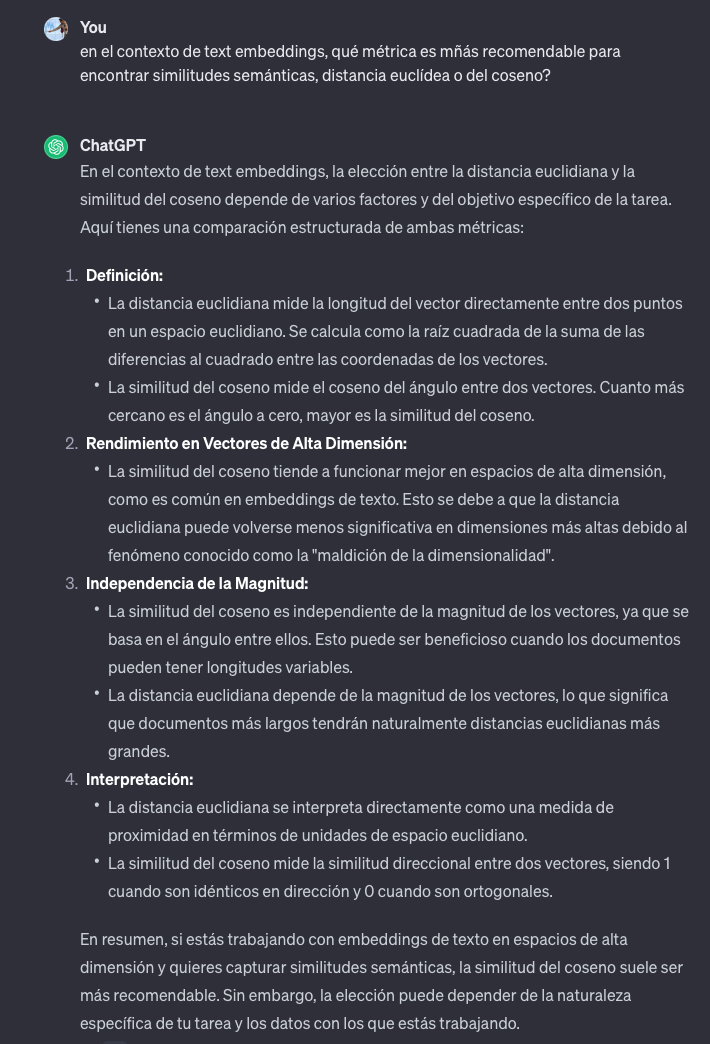

✅ En cambio, si obtenemos los embeddings del BertModel (con "bert-base-uncased") parece tener más sentido, al menos con estas palabras:

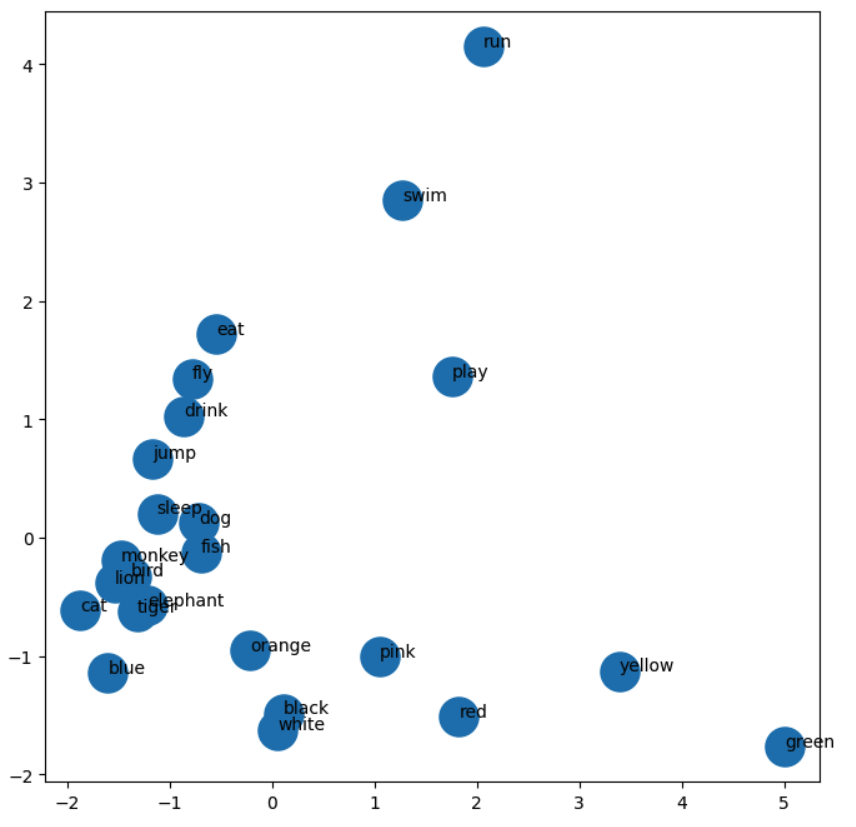

In [20]:
from transformers import BertModel, BertTokenizer
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model_bert = BertModel.from_pretrained(model_name) #), cache_dir=DA.paths.datasets+"/models")
tokenizer = BertTokenizer.from_pretrained(model_name) #, cache_dir=DA.paths.datasets+"/models")


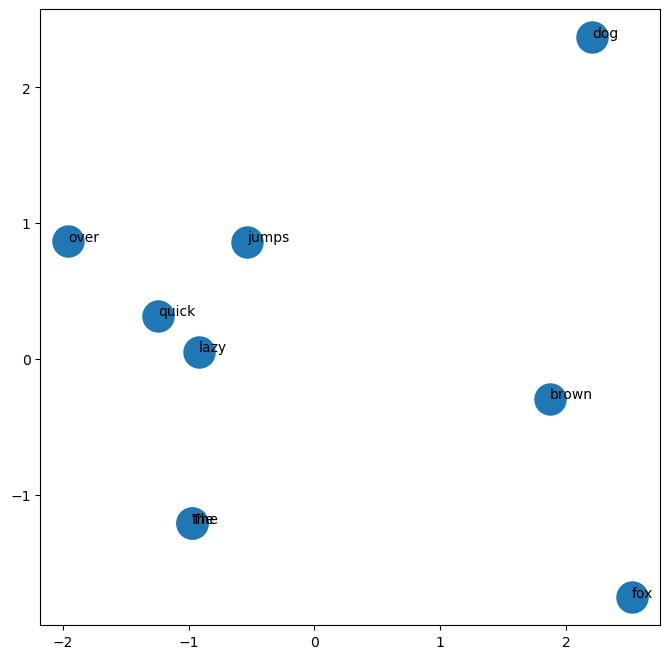

In [61]:
words = ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]

# Get the embeddings of the words
embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model_bert(**inputs)
    embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

Y con otro vocab:

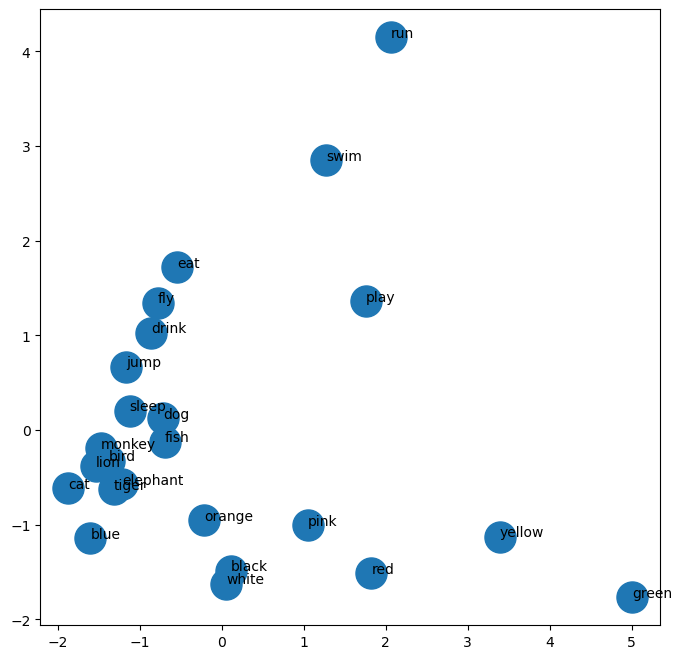

In [62]:
words = [
    # Animals
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    # Colors
    "red", "green", "blue", "yellow", "black", "white", "pink", "orange",
    # Verbs
    "run", "jump", "swim", "fly", "eat", "drink", "sleep", "play"
]
# Get the embeddings of the words
embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model_bert(**inputs)
    embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()